# L-curve for tsNMF rank=3

We plot the tsNMF results at rank=3 for multiple runs with different initial conditions using the "L-curve" format, on the MSE (mean squared error) vs SMC (smoothness regularization cost) plane.

The tsNMF parameters included are:
- smoothness parameter ($\eta$) =1e2-5e8
- sparsity parameter ($\lambda$) =0
- early-stopping using the `'cost'` criteria with the default stopping parameters.

In [1]:
import os
import glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dill

## Load MVBS data

In [2]:
MVBS_PCP_path = '../data/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
low_rank = MVBS_rpca['low_rank']
n_observations, n_frequencies, n_depth_levels, n_pings = low_rank.shape

In [4]:
low_rank = low_rank.values.reshape([n_observations,-1])

In [5]:
low_rank_nonneg = low_rank - low_rank.min()
low_rank_nonneg.shape

(62, 15984)

## Compute MSE and SMC for pre-calculated tsNMF runs

In [6]:
tsNMF_path = '../../ooi_sonar/nmf_paper_analysis_files/hpc_results/smoothness_sweep_dict/'

In [7]:
tsNMF_subfolder = ['sm%de%d_sp0'%(x,y) for y in [2,3,4,5,6,7,8] for x in [1,2,5]]
tsNMF_subfolder

['sm1e2_sp0',
 'sm2e2_sp0',
 'sm5e2_sp0',
 'sm1e3_sp0',
 'sm2e3_sp0',
 'sm5e3_sp0',
 'sm1e4_sp0',
 'sm2e4_sp0',
 'sm5e4_sp0',
 'sm1e5_sp0',
 'sm2e5_sp0',
 'sm5e5_sp0',
 'sm1e6_sp0',
 'sm2e6_sp0',
 'sm5e6_sp0',
 'sm1e7_sp0',
 'sm2e7_sp0',
 'sm5e7_sp0',
 'sm1e8_sp0',
 'sm2e8_sp0',
 'sm5e8_sp0']

### Compute MSE and SMC for all results

This will take some time to run:

In [8]:
mse_all_rank = dict()
smc_all_rank = dict()
for sss in tsNMF_subfolder:
    print(sss)
    fname = sorted(glob.glob(os.path.join(tsNMF_path, sss, '*.pkl')))
    mse_this_rank = []  # list to store results for the current rank
    smc_this_rank = []
    for ff in fname:
        with open(ff,'rb') as openfile:
            x = dill.load(openfile)
        mse_tmp = []  # list to store results from the current file
        smc_tmp = []
        for mm in x:
            mse_tmp.append(  # MSE
                np.linalg.norm(low_rank_nonneg.T - mm['W']@mm['H'])**2/low_rank_nonneg.size
            )
            smc_tmp.append(  # SMC
                np.linalg.norm(mm['H'][:,1:] - mm['H'][:,:-1])**2
            )
        mse_this_rank += mse_tmp  # concat all results within the current rank
        smc_this_rank += smc_tmp
    mse_all_rank[sss] = mse_this_rank  # store all results in this subfolder
    smc_all_rank[sss] = smc_this_rank

sm1e2_sp0
sm2e2_sp0
sm5e2_sp0
sm1e3_sp0
sm2e3_sp0
sm5e3_sp0
sm1e4_sp0
sm2e4_sp0
sm5e4_sp0
sm1e5_sp0
sm2e5_sp0
sm5e5_sp0
sm1e6_sp0
sm2e6_sp0
sm5e6_sp0
sm1e7_sp0
sm2e7_sp0
sm5e7_sp0
sm1e8_sp0
sm2e8_sp0
sm5e8_sp0


`mse_all_rank` and `smc_all_rank` are indexed by subfolder names. Let's reshape each dictionary entry so that we can easily index out the desired rank later.

In [9]:
# reshape for convenient access to results at each rank
num_run_per_rank = 320
for k,v in mse_all_rank.items():
    mse_all_rank[k] = np.array(v).reshape(-1,num_run_per_rank)  # reshape to [num_run x rank]
for k,v in smc_all_rank.items():
    smc_all_rank[k] = np.array(v).reshape(-1,num_run_per_rank)  # reshape to [num_run x rank]

## L-curve: MSE vs SMC for all smoothness parameter

In [10]:
# check the dimensions we're working with
mse_all_rank['sm1e2_sp0'].shape

(8, 320)

In [11]:
# the loaded results contain rank=2-9
rank_all = np.arange(2,10)

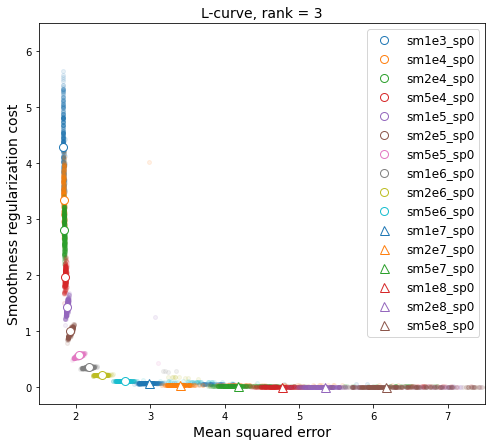

In [12]:
# L-curve in linear scale
rank_to_check = 3
subfolder_to_include = [tsNMF_subfolder[3]] + tsNMF_subfolder[6:]

r_idx = np.argwhere(rank_all==rank_to_check)[0][0].squeeze()
hl_all = []
hp_all = []

plt.figure(figsize=(8,7))
for seq, param in enumerate(subfolder_to_include):
    hl = plt.plot(mse_all_rank[param][r_idx,:], 
                  smc_all_rank[param][r_idx,:], '.', alpha=0.1, markersize=8)
    hl_all.append(hl[0])
for seq, param in enumerate(subfolder_to_include):
    if seq<10:        
        hp = plt.plot(np.median(mse_all_rank[param][r_idx,:]), 
                      np.median(smc_all_rank[param][r_idx,:]), 'o', 
                      color=hl_all[seq].get_color(), markerfacecolor='w', 
                      markersize=8, markeredgewidth=1)
    else:
        hp = plt.plot(np.median(mse_all_rank[param][r_idx,:]), 
                      np.median(smc_all_rank[param][r_idx,:]), '^', 
                      color=hl_all[seq].get_color(), markerfacecolor='w', 
                      markersize=9, markeredgewidth=1)        
    hp_all.append(hp[0])
    
plt.legend(hp_all, subfolder_to_include, fontsize=12)
plt.title('L-curve, rank = %d' % rank_to_check, fontsize=14)
plt.xlabel('Mean squared error', fontsize=14)
plt.ylabel('Smoothness regularization cost', fontsize=14)
plt.xlim(1.5, 7.5)
plt.ylim(-0.3, 6.5)
plt.show()

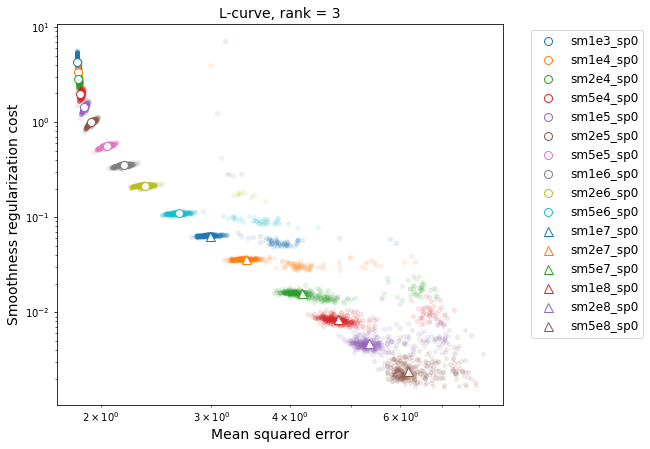

In [13]:
# L-curve in log scale
rank_to_check = 3
subfolder_to_include = [tsNMF_subfolder[3]] + tsNMF_subfolder[6:]

r_idx = np.argwhere(rank_all==rank_to_check)[0][0].squeeze()
hl_all = []
hp_all = []

plt.figure(figsize=(8,7))
for seq, param in enumerate(subfolder_to_include):
    hl = plt.plot(mse_all_rank[param][r_idx,:], 
                  smc_all_rank[param][r_idx,:], '.', alpha=0.1, markersize=8)
    hl_all.append(hl[0])
for seq, param in enumerate(subfolder_to_include):
    if seq<10:        
        hp = plt.plot(np.median(mse_all_rank[param][r_idx,:]), 
                      np.median(smc_all_rank[param][r_idx,:]), 'o', 
                      color=hl_all[seq].get_color(), markerfacecolor='w', 
                      markersize=8, markeredgewidth=1)
    else:
        hp = plt.plot(np.median(mse_all_rank[param][r_idx,:]), 
                      np.median(smc_all_rank[param][r_idx,:]), '^', 
                      color=hl_all[seq].get_color(), markerfacecolor='w', 
                      markersize=9, markeredgewidth=1)        
    hp_all.append(hp[0])
    
plt.xscale('log')
plt.yscale('log')    
plt.legend(hp_all, subfolder_to_include, bbox_to_anchor=(1.05, 1), fontsize=12)
plt.title('L-curve, rank = %d' % rank_to_check, fontsize=14)
plt.xlabel('Mean squared error', fontsize=14)
plt.ylabel('Smoothness regularization cost', fontsize=14)
plt.show()

## Fig. SX. L-curve at rank=3

In [14]:
def plot_spread(axx):
    for seq, param in enumerate(subfolder_to_include):
        hl = axx.plot(mse_all_rank[param][r_idx,:], 
                      smc_all_rank[param][r_idx,:], '.', 
                      alpha=0.1, markersize=3)
        hl_all.append(hl[0])
    for seq, param in enumerate(subfolder_to_include):
        if seq<7:        
            hp = axx.plot(np.median(mse_all_rank[param][r_idx,:]), 
                          np.median(smc_all_rank[param][r_idx,:]), 'o', 
                          color=hl_all[seq].get_color(), markerfacecolor='w', 
                          markersize=4, markeredgewidth=1)
        else:
            hp = axx.plot(np.median(mse_all_rank[param][r_idx,:]), 
                          np.median(smc_all_rank[param][r_idx,:]), '^', 
                          color=hl_all[seq].get_color(), markerfacecolor='w', 
                          markersize=4.5, markeredgewidth=1)        
        hp_all.append(hp[0])

In [15]:
rank_to_check = 3
subfolder_to_include = [tsNMF_subfolder[3]] + tsNMF_subfolder[6:]

In [16]:
panel_ls = 11
axis_ls = 11
tick_ls = 9
other_ls = 11

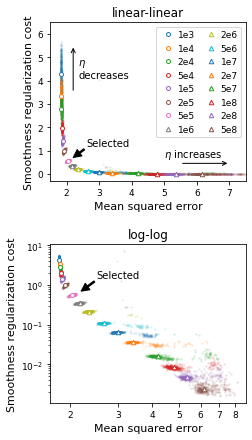

In [17]:
# L-curve in linear and log scale
r_idx = np.argwhere(rank_all==rank_to_check)[0][0].squeeze()
hl_all = []
hp_all = []

fig, ax = plt.subplots(2, 1, figsize=(3.5,7))
plt.subplots_adjust(hspace=0.4)

# linear-linear plot
plot_spread(ax[0])    
ax[0].tick_params(labelsize=tick_ls)
ax[0].legend(hp_all, [x[2:5] for x in subfolder_to_include], fontsize=tick_ls, 
             ncol=2, handletextpad=0.05, columnspacing=0.8)
ax[0].set_xlabel('Mean squared error', fontsize=axis_ls)
ax[0].set_ylabel('Smoothness regularization cost', fontsize=axis_ls)
ax[0].set_xlim(1.5, 7.5)
ax[0].set_ylim(-0.3, 6.5)
ax[0].set_title('linear-linear', fontsize=12)

# log-log plot
plot_spread(ax[1])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].tick_params(labelsize=tick_ls)
ax[1].set_xticks(np.arange(2,9))
ax[1].set_xticklabels(np.arange(2,9))
ax[1].set_xlabel('Mean squared error', fontsize=axis_ls)
ax[1].set_ylabel('Smoothness regularization cost', fontsize=axis_ls)
ax[1].set_title('log-log', fontsize=12)

# Annotation
ax[0].annotate('Selected', xy=(2.2, 0.7), xytext=(2.6, 1.2),
               arrowprops=dict(facecolor='black', shrink=0, width=1.5, headwidth=8, headlength=8),
              )
ax[1].annotate('Selected', xy=(2.2, 0.7), xytext=(2.5, 1.5),
               arrowprops=dict(facecolor='black', shrink=0, width=1.5, headwidth=8, headlength=8),
              )
ax[0].text(x=5, y=0.7, s='$\eta$ increases')
ax[0].annotate('', xy=(7, 0.45), xytext=(5.5, 0.45),
               arrowprops=dict(arrowstyle='->', facecolor='black'),
              )
ax[0].text(x=2.35, y=4.1, s='$\eta$\ndecreases')
ax[0].annotate('', xy=(2.2, 5.5), xytext=(2.2, 3.5),
               arrowprops=dict(arrowstyle='->', facecolor='black'),
              )

# Save figure
fig.savefig('../figs/fig_si_L_curve.png',
            dpi=300, bbox_inches = 'tight', pad_inches = 0.05)

plt.show()